# Soft Robot Manipulator Kinematics 
Pradeep Janakiraman (SIMTech)

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d.axes3d import Axes3D
from math import *

# magic commands
%matplotlib notebook
%matplotlib inline

# set display parameters for arrays and figures
np.set_printoptions(precision=3)
label_size = 8
mpl.rcParams['xtick.labelsize'] = label_size 

## 0.1 Getting appropriate lengths based on presence or absence of backbone

Each soft actuator has 3 chambers and provides 2 degrees of freedom, making it an overactuated system. However, the actuator can be fitted with a <b>fixed length</b> backbone, in which case only 2 chamber lenghts are needed to determine the full configuration of the system. Assuming that the actuator is symmetric and the backbone is placed in the center of the actuator, the following formula can be used to determine either the backbone lenght or the lenght of the 3 chamber. In the formula below, $l_{b}$ is the length of the backbone. 

\begin{equation} 
    l_{b} = \frac{l_{1} + l_{2} + l_{3}}{3}
\end{equation}

In [2]:
# Function to process chamber lengths 
def getLengths(lengths, actuation, backbone, mode): 
    """ Computes the configuration variables theta and phi given 3 lenghts of the chambers. 
    The function takes in 4 arguments: computeConfig(lenghts, actuation, backbone, mode). 
    lenghts: A 1 by 3 tuple containing the lenghts of the 3 chambers. 
    actuation: Which chambers are activated - corresponds with the lenghts tuple. Actuated chambers denoted by 1 and unactivated given by 0.
    Eg: lenghts = (4, 2, 2), actuation = (1, 1, 0). This implies the first chambers in lenghts are activated and the third one is not. 
    backbone: Lenght of the backbone. 
    mode: Boolean to indicate whether we are dealing with a fixed backbone or flexible one that back change length. """
    
    # check if backbone is fixed and if it is compute the determined length from the chambers that are actuated 
    # if backbone is fixed, then only two chamber lengths are needed to compute the configuration of the robot where the length configuration is the length of the backbone
    if mode: 
        Flengths = ()
        Fbackbone = backbone
        for i in range(0, len(actuation)): 
            if not actuation[i]: 
                DetCham = 3*backbone - sum(lengths) + lengths[i]
        for j in range(0, len(actuation)): 
            if actuation[j] == 1: 
                Flengths += (lengths[j], )
            else: 
                Flengths += (DetCham, )
    else: 
        Flengths = lengths
        Fbackbone = (lengths[0] + lengths[1] + lengths[2])/3
    return (Flengths, Fbackbone)

## 0.2 Finding the remaining configuration variables $\phi$ and $\theta$

In the previous section the appropriate lenghts were found (including backbone length), and based on that the configuration variables $\phi, \theta$ can be found. The following figure illustrates the convention that is adopted for our soft actuator which highlights the naming convention of the chambers and the various terms that will be used for the formulation. 

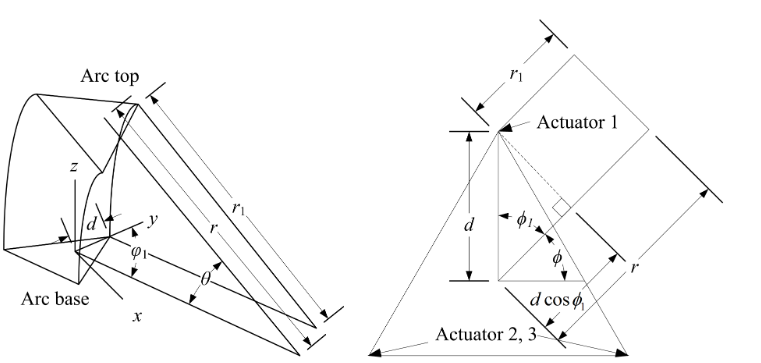
Figure above shows the arc parameters and the other variables used in formulation. 

Based on the construction above, the configuration variables can be found with the following: 

\begin{align}
    \phi &= \tan^{-1}(\frac{\sqrt{3}(l_{2} + l_{3} - 2l_{1})}{3(l_{2} - l_{3})})\\
    \theta &= l_{b} \cdot \frac{2\sqrt{l_{1}^{2} + l_{2}^{2} + l_{3}^{2} - l_{1}l_{2} - l_{1}l_{3} - l_{2}l_{3}}}{d(l_{1} + l_{2} + l_{3})}
\end{align}

In [3]:
# function to compute phi, theta - the two configuration variables of the soft robot 
def computeConfig(lengths, actuation, backbone, mode, ChamDist): 
    """ Returns the tuple (phi, theta) which are the configuration variables of a 2dof soft robot that is controlled 
    by changing the length of 3 different chambers. Takes in 5 arguments where the first 4 arguments are similar to
    the getLength function refer to the instrcution in the docstring for getLength. The last additional argument is the
    distance from the center to the chambers (assuming equidistance arrangement of the chambers)."""
    
    (Flengths, Fbackbone) = getLengths(lengths, actuation, backbone, mode)
    
    NumPhi = np.sqrt(3)*(Flengths[1] + Flengths[2] - 2*Flengths[0])
    DenPhi = 3*(Flengths[1] - Flengths[2])
    
    NumKap = 2*np.sqrt(Flengths[0]**2 + Flengths[1]**2 + Flengths[2]**2 - Flengths[0]*Flengths[1] - Flengths[0]*Flengths[2] - Flengths[1]*Flengths[2])
    DenKap = ChamDist*(Flengths[0] + Flengths[1] + Flengths[2])
    
    phi = np.rad2deg(np.arctan2(NumPhi, DenPhi))
    
    theta = np.rad2deg(Fbackbone*(NumKap/DenKap))
    
    return (phi, theta)

## 0.3 Testing the functions 

In [4]:
# test getLength 
lengths = (65, 30, 30)
actuation = (True, False, True)
backbone = 60
mode = True 

getLengths(lengths, actuation, backbone, mode)

((65, 85, 30), 60)

In [5]:
# test computeConfig 
ChamDist = 62
phi, theta = computeConfig(lengths, actuation, backbone, mode, ChamDist)

In [6]:
(phi, theta)

(-8.948275564627082, 29.70647783349575)

## 1. Forward Kinematics

### 1.1 Finding tip frame configuration for one actuator

With the configuration variables determined. The task space coordinates $(x, y, z)$ can now be found by attaching a coordinate frame to the tip. The tip frame will be represented by a trasnformation matrix which can be described using the conventions shown below. 
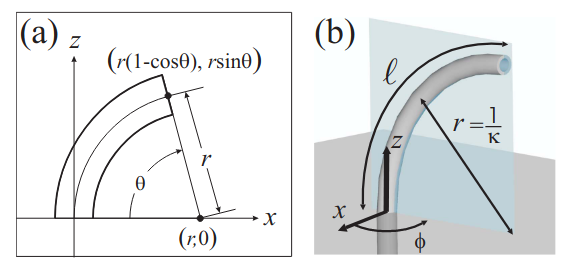

The tip frame can then be formulated as follows: 
\begin{equation} 
    T = \begin{bmatrix} 
        R_{z}(\phi) & 0 \\
        0 & 1
        \end{bmatrix} 
        \begin{bmatrix} 
        R_{y}(\theta) & \vec{p}\\
        0 & 1
        \end{bmatrix}
\end{equation}

The right hand coordinate system is adopted and from that the rotation matrices can be derived: 

\begin{align} 
    R_{z}(\phi) &= \begin{bmatrix} 
       \cos(\phi) & -\sin(\phi) & 0\\
        \sin(\phi) & \cos(\phi) & 0\\
        0 & 0 & 1
        \end{bmatrix}\\ 
    R_{y}(\theta) &= \begin{bmatrix} 
        \cos(\theta) & 0 & \sin(\phi)\\
        0 & 1 & 0\\
        -\sin(\theta) & 0 & \cos(\theta)
        \end{bmatrix}\\
    \vec{p} &= \begin{bmatrix}
         r(1-\cos(\theta))\\
         0\\
         r\sin(\theta)
         \end{bmatrix}
\end{align}

In [7]:
# function to find the tip frame of a single actuator (forward kinematics)
def fKinematicsSingle(phi, theta, backbone): 
    """ Computes the coordinates of the tip of one module based on the given phi and omega values. Phi should be the
    out of plane bending, while omega is the in plane bending angle."""
    # derive radius = l/theta 
    radius = backbone/(np.deg2rad(theta))
    phi = np.deg2rad(phi)
    theta = np.deg2rad(theta)
    # rotation matrix for rotation about z axis 
    Rz = np.array([[cos(phi), -sin(phi), 0], [sin(phi), cos(phi), 0], [0, 0, 1]])
    # rotation matrix for rotation about y axis 
    Ry = np.array([[cos(theta), 0, sin(theta)], [0, 1, 0], [-sin(theta), 0, cos(theta)]])
    # tip position in intermediate frame (frame rotated about z axis)
    p = np.array([[radius*(1-cos(theta))], [0],[radius*sin(theta)]])
    
    # Frame configurations 
    # Tip frame for first rigid body rotation about z axis 
    TipFz = np.concatenate((np.concatenate((Rz, np.zeros((3, 1))), axis=1), np.array([[0,0,0,1]])), axis=0)
    # Tip frame for second rigid body transformation about y axis and translation given by p 
    TipFy = np.concatenate((np.concatenate((Ry, p), axis=1), np.array([[0,0,0,1]])), axis=0)
    # Full tip frame 
    TipFinal = np.dot(TipFz, TipFy)
    
    return TipFinal

In [8]:
TipFinal = fKinematicsSingle(phi, theta, backbone)

In [9]:
TipFinal

array([[ 0.858,  0.156,  0.49 , 15.024],
       [-0.135,  0.988, -0.077, -2.366],
       [-0.496,  0.   ,  0.869, 57.348],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [10]:
TipFinal[0:3, 3]

array([15.024, -2.366, 57.348])

### 1.2 Finding tip frame configuration for multiple serial actuators connected together

Once we have the formaultion for the transformation matrix representing the tip of one actuator, computing the tip of a serial manipulator is just a matter of finding the combined transformation matrix for all the actuators. Assuming 0 is the base frame and $1,...n$ are the coordinate frames attached to the tip of the actuators connected in serial. Then the overall transformation matrix is given by: 

\begin{equation}
    {}^{0}T_{n} = {}^{0}T_{1}{}^{1}T_{2}{}^{2}T_{3}\cdots{}^{n-1}T_{n}
\end{equation}

One the system transformation matrix is found, the task space coordinates can found with respect to the base frame simply by: 
\begin{equation} 
    {}^{0}\vec{p} = {}^{0}T_{n}{}^{n}\vec{p}
\end{equation}

In [11]:
#function to create the matrix of configuration variables 
def buildRobot(): 
    """ Computed the length matrix of the form [l11, l21, l31; ...; ln1, ln2, ln3] where
    all the elements are specified by the user."""
    # number of actuators 
    NActuators = int(input("Enter the number of actuators: "))
    
    StListConfig = [0, 0, 0]
    StListStates = [0, 0, 0]
    Configs = np.empty((NActuators, 3))
    ActuatedChm = np.empty((NActuators, 3))
    
    for i in range(0, NActuators): 
        k = i+1
        StrInputConf = input("Enter the list of chamber lengths for actuator %d. Enter in the format - l1 l2 l3: " %k)
        StrInputStates = input("Enter the a tuple with boolean values indicating which actuator is switched off for actuator %d: " %k)
        SplitInputConfig = StrInputConf.split()
        SplitInputStates = StrInputStates.split()
        for j in range(0, 3): 
            StListConfig[j] = float(SplitInputConfig[j])
            StListStates[j] = float(SplitInputStates[j])
        Configs[i, :] = StListConfig
        ActuatedChm[i, :] = StListStates
    return (Configs, ActuatedChm)

In [12]:
params = buildRobot()

Enter the number of actuators: 3
Enter the list of chamber lengths for actuator 1. Enter in the format - l1 l2 l3: 12 23 34
Enter the a tuple with boolean values indicating which actuator is switched off for actuator 1: 1 1 0 
Enter the list of chamber lengths for actuator 2. Enter in the format - l1 l2 l3: 23 34 45
Enter the a tuple with boolean values indicating which actuator is switched off for actuator 2: 0 1 1
Enter the list of chamber lengths for actuator 3. Enter in the format - l1 l2 l3: 34 45 56
Enter the a tuple with boolean values indicating which actuator is switched off for actuator 3: 1 0 1


In [13]:
params

(array([[12., 23., 34.],
        [23., 34., 45.],
        [34., 45., 56.]]),
 array([[1., 1., 0.],
        [0., 1., 1.],
        [1., 0., 1.]]))

In [14]:
#function that finds the tip position of the serial soft manipulator
def fKinematicsSerial(params, backbone, mode, ChmDist): 
    """Find the transformation matrix that represents the tip frame of serial soft manipulator that is connected in
    a piecewise manner. Takes in two inputs: 1. params - which contains a matrix which lenght variables of each actuator 
    (a Nx3 matrix) where N is the number of actuators connected and another matrix with information on which actuators are being
    actuated. 2. mode - True means that there is a backbone and the actuator is overactuated while false implies no backbone. 
    """
    # obtain the number of actuators in the robot, N
    NActuators = params[0].shape[0]
    # initialise configuration matrix with size (N, 2)
    Configs = np.zeros((NActuators, 2))
    
    # compute the configuration variables for each actuator
    for i in range(0, NActuators): 
        Configs[i] = computeConfig(params[0][i, :], params[1][i, :], backbone, mode, ChmDist)
        
    # add a column of backbone lenghts to the Configs matrix, in this case all actuators are assumed to have
    # the same backbone length 
    Backbone_col = backbone*np.ones((NActuators, 1))
    Configs = np.concatenate((Configs, Backbone_col), axis=1)
    
    # initialise Tip frame matrix 
    TipFrame = np.identity(4)
    
    # for each actuator, find the tip frame, and multiply it with the previous tip frame 
    for j in range(0, NActuators): 
        CurrFrame = fKinematicsSingle(Configs[j, 0], Configs[j, 1], backbone)
        TipFrame = np.matmul(TipFrame, CurrFrame)
    
    return (Configs, TipFrame)
    

In [15]:
Configs, TipFrame = fKinematicsSerial(params, backbone, mode, ChamDist)

In [16]:
TipFrame

array([[ 5.875e-01, -8.089e-01,  2.247e-02, -7.065e+01],
       [-1.556e-01, -8.568e-02,  9.841e-01,  1.247e+02],
       [-7.941e-01, -5.816e-01, -1.762e-01,  5.868e+01],
       [ 0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00]])

In [17]:
Configs

array([[145.727,  78.77 ,  60.   ],
       [-98.805,  38.341,  60.   ],
       [ 52.947,  30.106,  60.   ]])

## 2. Reachable space

### 2.1 Generating the pointcloud for one actuator 

It is quite clear that with more actuators, the overall resulting manipulator can reach more areas in 3D space. In order to find the reachability of an N-actuator manipulator, the reachable space of a single acuator can be found first. In order to do so limits have to set on the configuration variables, as $\phi$ and $\theta$ are not valid over all real numbers $\mathcal{R}$. The limits we set are as follows: 
\begin{align} 
    -30^{\circ} &\leq \theta \leq 30^{\circ}\\
    -180^{\circ} &\leq \phi \leq 180^{\circ}
\end{align}
    

In [18]:
def getPoints(N, phiMin, phiMax, thetaMin, thetaMax, backbone): 
    """ Function to get points in 3D space that correspond to the position of a tip of a single actuator based on
    different configuration variables of phi and theta that are subject to max, min constraints. N is the 
    number of values desired for phi and theta, which would then generate N points. """
    
    # get arrays of configuration variables, step size based on N
    phi_values = np.linspace(phiMin, phiMax, N)
    theta_values = np.linspace(thetaMin, thetaMax, N)
    
    # initialise collection of points 
    Point_cloud = np.zeros((N, 3, N))
    
    # populate points into point cloud
    for i in range(0, N): 
        phi = phi_values[i]
        for j in range(0, N): 
            theta = theta_values[j]
            Point_cloud[i, :, j] = fKinematicsSingle(phi, theta, backbone)[0:3, 3]
                
    return Point_cloud

### 2.2 Visualising the pointcloud

In [19]:
def pointCloud(N, phiMin, phiMax, thetaMin, thetaMax, backbone): 
    """ Generates a 3D point cloud of the reachable points of a single actuator. """
    # create pointcloud
    Point_cloud = getPoints(N, phiMin, phiMax, thetaMin, thetaMax, backbone)
    # Create 3D plot
    fig = plt.figure(figsize = (3,3), dpi= 200)
    ax = fig.add_subplot(projection='3d')
    
    for i in range(0, N): 
        for j in range(0, N): 
            Xp = Point_cloud[i][0, j]
            Yp = Point_cloud[i][1, j]
            Zp = Point_cloud[i][2, j]
            ax.scatter(Xp, Yp, Zp, marker = 'o', color = 'green')
            
    # label the axes        
    ax.set_xlabel("$x$ [mm]")
    ax.set_ylabel('$y$ [mm]')
    ax.set_zlabel('$z$ [mm]')
    
    # set plot range for z axis: 
    ax.set_zlim([0, 60])
    
    return plt.show()
            

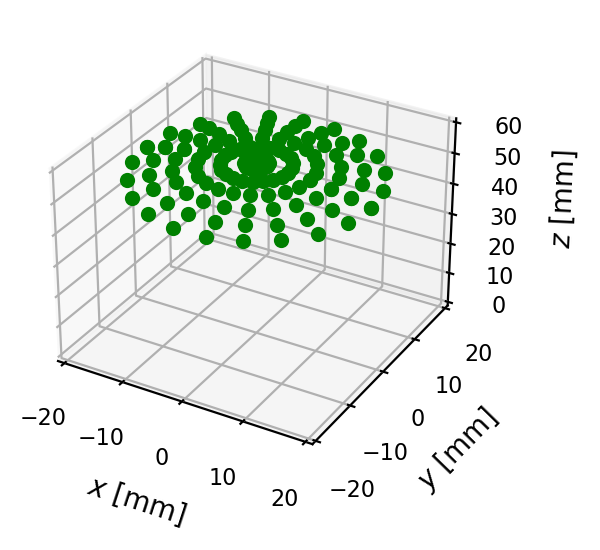

In [20]:
pointCloud(12, -180, 180, -40, 40, 55)

### 2.3 Generating the pointcloud for serial manipulators ($n$ = 3)

In [21]:
# function to generate Tip Frame based on just configuration variables
# the previous function to generate tip frame takes in length inputs 
def getTipFrame(Configs, backbone): 
    """ Generates Tip Frame based on configs input (phi, theta) instead of fKinematicsSerial which takes in
    length input"""
    
  # initialise tip frame 
    TipFrame = np.identity((4, 4))
    
    for i in range(0, Configs.shape[1]): 
        CurrFrame = fKinematicsSingle(Configs[i, 0], Configs[i, 1], backbone)
        TipFrame *= CurrFrame
    
    return TipFrame
        

In [22]:
 def getPointsSerial(N, phiMin, phiMax, thetaMin, thetaMax, backbone): 
    """ Generates the point cloud for a serial manipulator with the number of actuators = NActuators. The 
    number of data points = N and the other arguments are same as in the single actuator function. Refer to
    getPoints for details or read the section above. """
    
    # Function can only be used for 3 actuators 
    NActuators = 3; 
    
    # initialise matrix of transformation matrices 
    # 4-D matrix
    BigT = np.zeros((NActuators, N, N, 4, 4))
    
    # get arrays of configuration variables, step size based on N
    phi_values = np.linspace(phiMin, phiMax, N)
    theta_values = np.linspace(thetaMin, thetaMax, N)
    
    # populate the BigT matrix (no of actuators, phi, theta, (4, 4) - for transformation)
    for i in range(0, NActuators): 
        for j in range(0, N): 
            phi = phi_values[j]
            for k in range(0, N): 
                theta = theta_values[k]
                BigT[i, j, k, :, :] = fKinematicsSingle(phi, theta, backbone)
                
    # intitiate point cloud matrix
    Cloud = np.zeros((3, 1))
    
    # there are 6 dof for a 3 actuator manipulator
    for phi1 in range(0, N):
        for theta1 in range(0, N): 
            for phi2 in range(0, N):
                for theta2 in range(0, N): 
                    Submulmat = np.dot(BigT[0, phi1, theta1], BigT[1, phi2, theta2])
                    for phi3 in range(0, N): 
                        for theta3 in range(0, N): 
                            Point = np.dot(Submulmat, BigT[2, phi3, theta3])[0:3, 3].reshape(3, 1)
                            Cloud = np.concatenate((Cloud, Point), axis = 1)
                            
                            
    return Cloud

In [23]:
Cloud = getPointsSerial(4, -180, 180, -30 ,30, 55)

In [24]:
Cloud.shape # number of points in point cloud will be the number of columns 

(3, 4097)

In [25]:
backbone

60

### Visualising the point cloud for serial manipulator ($n$ = 3)

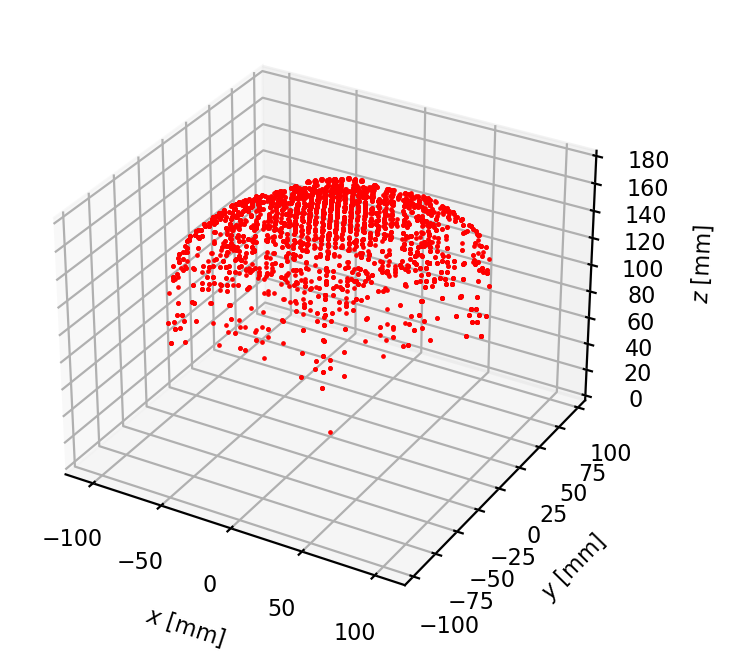

In [27]:
# plot 3D plot of the Cloud object 
figSerial = plt.figure(figsize = (4, 4), dpi = 200)
axSerial = figSerial.add_subplot(projection='3d')

for i in range(0, Cloud.shape[1]): 
    Xp = Cloud[0, i]
    Yp = Cloud[1, i]
    Zp = Cloud[2, i]
    axSerial.scatter(Xp, Yp, Zp, s = 2, marker = '.', color = 'red')
    
# label the axes        
axSerial.set_xlabel("$x$ [mm]", fontsize = 8)
axSerial.set_ylabel('$y$ [mm]', fontsize = 8)
axSerial.set_zlabel('$z$ [mm]', fontsize = 8)
    
# set plot range for z axis: 
axSerial.set_zlim([0, backbone*3])

plt.show()